In [ ]:
#https://www.kaggle.com/datasets/504743cb487a5aed565ce14238c6343b7d650ffd28c071f03f2fd9b25819e6c9?resource=download-directory

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
#from torch.utils.tensorboard import SummaryWriter

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(3,64,64)):
    image_tensor = (image_tensor + 1) / 2 #convert image to 0 1 because image passed as -1 to 1
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [3]:
def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

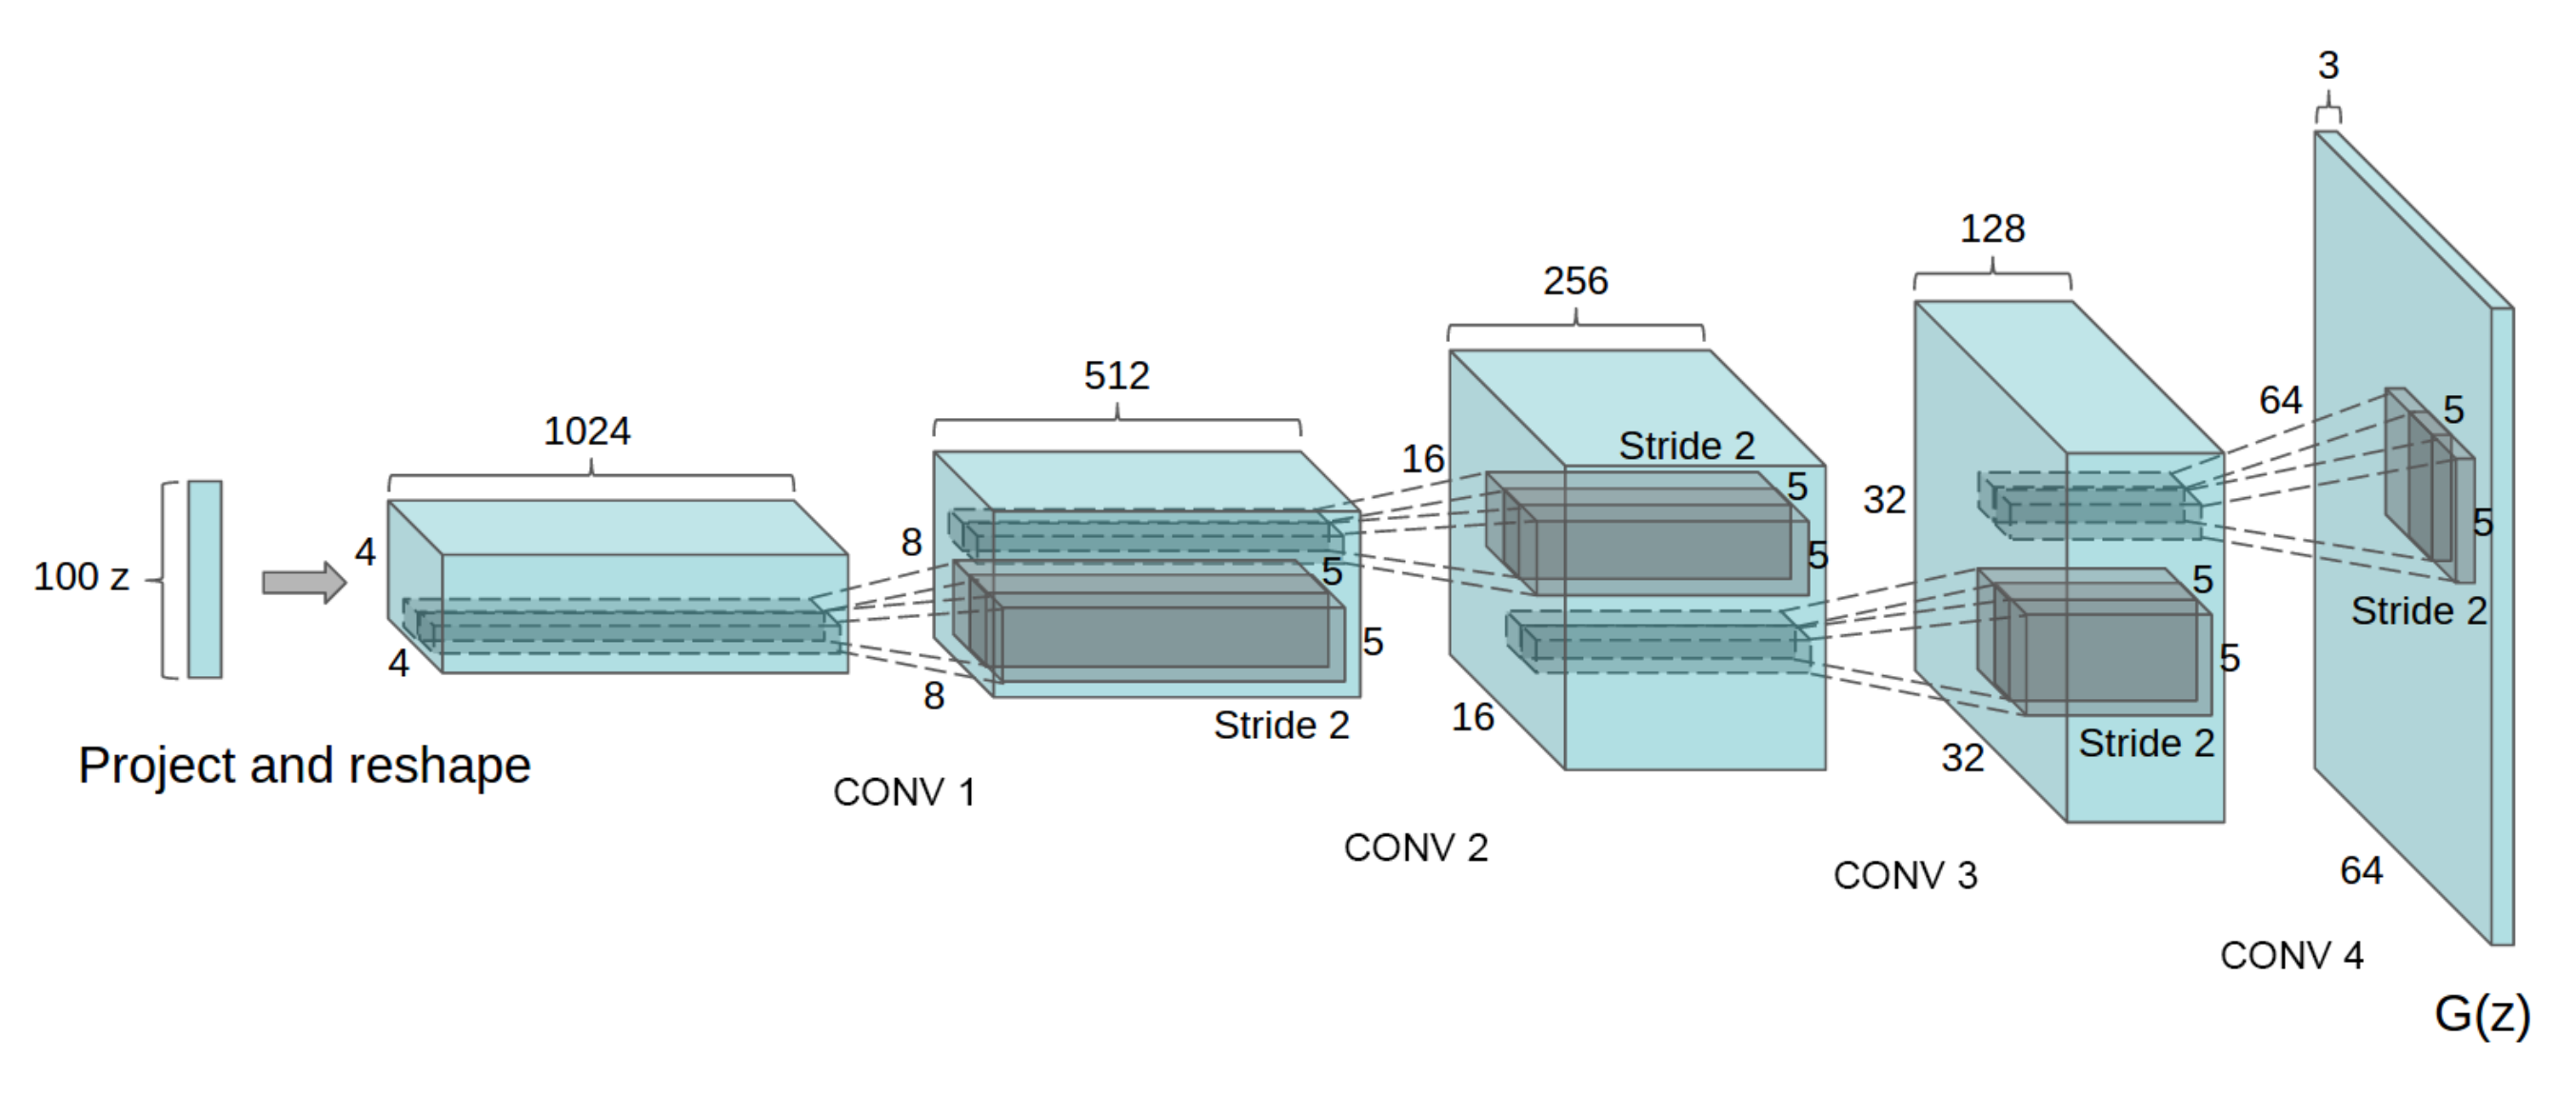

# Generator

In [4]:
class Generator(nn.Module):
    
    def __init__(self,z_dim,im_channels,hidden_dim):
        super(Generator,self).__init__()
        #image will be 128,100,1,1 noise should be 100x1x1 (don't worry just pass the noise and forward will make it 100x1x1)
        self.z_dim = z_dim
        self.gen = nn.Sequential(
        self.make_gen_block(z_dim , hidden_dim*16,kernel_size=4, stride=1,padding=0),  #1x1 will be 128*1024*4*4
        self.make_gen_block(hidden_dim*16 , hidden_dim*8),                        #512
        self.make_gen_block(hidden_dim*8 , hidden_dim*4),                      #256
        self.make_gen_block(hidden_dim*4 , hidden_dim*2),                       #128
        self.make_gen_block(hidden_dim*2 , im_channels,final_layer=True)    #3*64*64
        ) 
    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=2,padding=1, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride,padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                
            )
        else: # Final Layer
            return nn.Sequential(
                
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride,padding=padding),
                nn.Tanh()
                
            )

    def forward(self,noise):
        #want to insert 100 and convert it to (100,1,1) len(noise) so if you change the length later
        noise=noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(noise)   

# Create Noise Vector

In [5]:
def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
gen = Generator(100,3,64)
num_test = 128
test_hidden_block = gen.make_gen_block(100,16*64, kernel_size=4, stride=2,padding=0)
test_uns_noise = torch.rand((128,100,1,1))
hidden_output = test_hidden_block(test_uns_noise)
hidden_output.shape
#o=(n-1)*s+m
#m is kernalsize and s is strid
#7
#strid 4 and kernal 2 and padding 1 will do upsampling also better since you will save edges information while upsampling
#kernal_size=2 and strid 2 will double each time so you don't have to calculate each block what the kernel_size and strid

torch.Size([128, 1024, 4, 4])

# Discriminator

In [7]:
class Critic(nn.Module):
    
    #Reverse of generator start big and goes to 1 output 
    #64*2 64*4 ... to reach channels 1024 and downsample 64 of width and heigh to 1 
   
    def __init__(self, im_chan, hidden_dim): #hidden_dim will be 64
        
        super(Critic, self).__init__()
        
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim*2, hidden_dim * 4),
            self.make_disc_block(hidden_dim*4, hidden_dim * 8),
            self.make_disc_block(hidden_dim * 8, 1,padding=0, final_layer=True),
            )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2,padding=1, final_layer=False):

        if not final_layer:
            return nn.Sequential(
                
                nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride,padding=padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
                
            )
        else: # Final Layer
            return nn.Sequential(
                
                nn.Conv2d(input_channels, output_channels, kernel_size, stride,padding=padding),
                nn.Tanh()
                
            )

    def forward(self,x):
        disc_pred = self.disc(x)
        return disc_pred.view(len(disc_pred),-1) #x is the image
        

## Training Initializations
Now you can start putting it all together.
As usual, you will start by setting the parameters:
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum terms
  *   c_lambda: weight of the gradient penalty
  *   crit_repeats: number of times to update the critic per generator update - as we train the crit more than generator
  *   device: the device type

You will also load and transform the MNIST  dataset to tensors. testing


# Test

In [8]:
# disc = Discriminator(3,64)
# num_test = 128
# test_hidden_block = disc.disc_block(3,64, kernel_size=4, stride=2,padding=1)#3*64*64
# test_uns_noise = torch.rand((128,3,64,64))
# hidden_output = test_hidden_block(test_uns_noise)
# print(hidden_output.shape)

# #Block2
# test_hidden_block = disc.disc_block(64,64*2, kernel_size=4, stride=2,padding=1)#3*64*64
# hidden_output = test_hidden_block(hidden_output)
# print(hidden_output.shape)

# #block3
# test_hidden_block = disc.disc_block(64*2,64*4, kernel_size=4, stride=2,padding=1)#3*64*64
# hidden_output = test_hidden_block(hidden_output)
# print(hidden_output.shape)
# #block4
# test_hidden_block = disc.disc_block(64*4,64*8, kernel_size=4, stride=2,padding=1)#3*64*64
# hidden_output = test_hidden_block(hidden_output)
# print(hidden_output.shape)
# #block5
# test_hidden_block = disc.disc_block(64*8,1, kernel_size=4, stride=2,padding=0)#3*64*64
# hidden_output = test_hidden_block(hidden_output)
# print(hidden_output.shape)

In [9]:
#hidden_output.reshape(len(hidden_output),-1).shape # To see the output of 128 image as 128,1 true of false

# Weight Initializer

In [10]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [11]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Critic(in_channels, 8)
    print(disc(x).shape)
    assert disc(x).shape == (N,1), "Discriminator test failed" 
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Sucess")

In [12]:
test()

torch.Size([8, 1])
Sucess


# Traning
Now you can put it all together! Remember that these are your parameters:

criterion: the loss function          
n_epochs: the number of times you iterate through the entire dataset when training               
z_dim: the dimension of the noise vector              
display_step: how often to display/visualize the images           
batch_size: the number of images per forward/backward pass           
lr: the learning rate          
beta_1, beta_2: the momentum term          
device: the device type           

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS_IMG = 3 #we have to change it when we m
Z_DIM = 100
NUM_EPOCHS = 3
HIDDEN_DIM = 64
HIDDEN_DIM_DISC = 64
DISPLAY_STEP = 500
beta_1 = 0.5 
beta_2 = 0.999
crit_repeats = 5
c_lambda = 10

In [14]:
transform=transforms.Compose(
    [ 
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)],[0.5 for _ in range(CHANNELS_IMG)])
]
)

In [15]:
#dataset=MNIST(root="dataset/",train=True,transform=transform,download=False)
dataset=datasets.ImageFolder(root="D:\celeb_dataset",transform=transform)
dataloader = DataLoader(dataset=dataset,batch_size=BATCH_SIZE,shuffle=True)
feature,labels=next(iter(dataloader))
print(feature.shape)

torch.Size([128, 3, 64, 64])


## Visualizing the data 

torch.float32


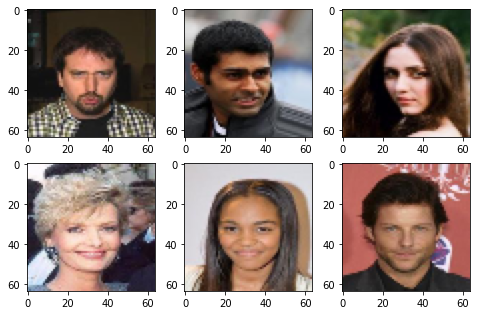

In [16]:
import numpy as np
plt.figure(figsize=(8,8))
for i in range(6):
    plt.subplot(3,3,i+1)
    image=(feature[i]+1)/2
    image=np.transpose(image,(1, 2, 0))
    plt.imshow(image)
    
print(feature[0].dtype)

In [32]:
gen = Generator(Z_DIM,CHANNELS_IMG,HIDDEN_DIM).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(beta_1, beta_2))

crit = Critic(CHANNELS_IMG,HIDDEN_DIM_DISC).to(device) 

crit_opt = torch.optim.Adam(crit.parameters(), lr=LEARNING_RATE, betas=(beta_1, beta_2))
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

## Gradient Penalty
Calculating the gradient penalty can be broken into two functions: (1) compute the gradient with respect to the images and (2) compute the gradient penalty given the gradient.

You can start by getting the gradient. The gradient is computed by first creating a mixed image. This is done by weighing the fake and real image using epsilon and then adding them together. Once you have the intermediate image, you can get the critic's output on the image. Finally, you compute the gradient of the critic score's on the mixed images (output) with respect to the pixels of the mixed images (input). You will need to fill in the code to get the gradient wherever you see *None*. There is a test function in the next block for you to test your solution.

In [26]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [27]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1) #take across the dimension that we just faltten. L2 norm
    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - 1)**2)
    #### END CODE HERE ####
    return penalty

## Losses
Next, you need to calculate the loss for the generator and the critic.

For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake images. The argument has the scores for all fake images in the batch, but you will use the mean of them.

There are optional hints below and a test function in the next block for you to test your solution.


In [28]:
def get_gen_loss(crit_fake_pred):
    gen_loss = -1. * torch.mean(crit_fake_pred)
    #we want to maxmize the crit loss when it take the fake_pred as input  , we do it by -1 trick since grident decent only 
    #used for minimize
    #minimize the distance by maximuize E(c(g(z))) so it close the E(c(x)) to output 0
    #i can make it mnimize(1-E(c(g(z)))) but the output is not sigmoid , the output is real number can exceeed 1 (point)
    return gen_loss

For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real images and the predictions on the fake images while also adding a gradient penalty. The gradient penalty is weighed according to lambda. The arguments are the scores for all the images in the batch, and you will use the mean of them.

There are hints below if you get stuck and a test function in the next block for you to test your solution.
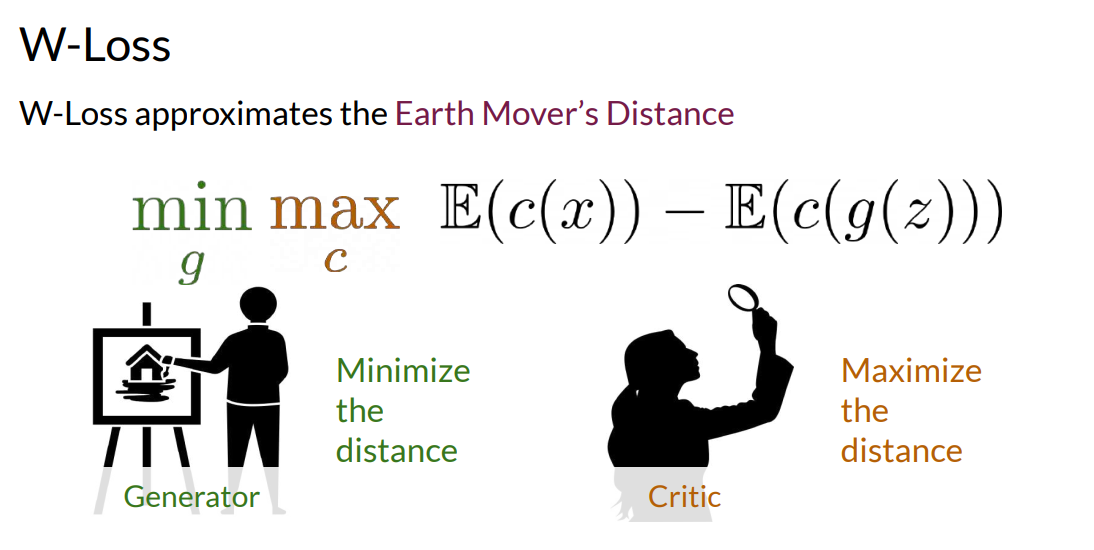

In [29]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp 
    #here it should also be -1(torch.mean(real_pred)-torch.mean(crit_fake_pred))+...  so we minimize the - so it will be maximized
    return crit_loss

## Putting It All Together
Before you put everything together, there are a few things to note.
1.   Even on GPU, the **training will run more slowly** than previous labs because the gradient penalty requires you to compute the gradient of a gradient -- this means potentially a few minutes per epoch! For best results, run this for as long as you can while on GPU.
2.   One important difference from earlier versions is that you will **update the critic multiple times** every time you update the generator This helps prevent the generator from overpowering the critic. Sometimes, you might see the reverse, with the generator updated more times than the critic. This depends on architectural (e.g. the depth and width of the network) and algorithmic choices (e.g. which loss you're using). 
3.   WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just **increases stability** and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN,though it will generally run a bit slower. You should also be able to train your model for more epochs without it collapsing.


<!-- Once again, be warned that this runs very slowly on a CPU. One way to run this more quickly is to download the .ipynb and upload it to Google Drive, then open it with Google Colab and make the runtime type GPU and replace
`device = "cpu"`
with
`device = "cuda"`
and make sure that your `get_noise` function uses the right device.  -->


In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(NUM_EPOCHS):
    for real,_ in dataloader:
        cur_batch_size = len(real) #redundant
        real=real.to(device)
        
        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
        
            crit.zero_grad()
            fake_noise=get_noise(cur_batch_size,Z_DIM,device=device) #don't forget passing device
            
            #Generate the images from this noise
            fake=gen(fake_noise)
            crit_fake_pred = crit(fake.detach()) #get only values not gident graph no update for generator happen
            crit_real_pred = crit(real)
            
            #Calculate loss using grident plenty
            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True) #this mean it will be traniable
            gradient = get_gradient(crit, real, fake.detach(), epsilon) #get grident of mixed image to save 1-L contuinouse
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)
            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
            
        critic_losses += [mean_iteration_critic_loss]    #sum of mean critic loss every 5 more traning steps in crit
            
        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, Z_DIM, device=device)
        
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2) #here no passes of labels 1 because it's no longer sigmoid or softmax in the end
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]
        
        
        ### Visualization code ###
        if cur_step % DISPLAY_STEP == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / DISPLAY_STEP
            crit_mean = sum(critic_losses[-display_step:]) / DISPLAY_STEP
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            #Grident visulaization
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1


# Test another code

In [34]:
import torch
torch.cuda.empty_cache()